# Installs

In [68]:
%%sh
pip3.9 install plotly > /dev/null
pip3.9 install numpy > /dev/null
pip3.9 install seaborn > /dev/null

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

# Import canisters

In [93]:
import json
import os
root = os.path.dirname(os.getcwd())

# with open(root+'/.dfx/local/canister_ids.json') as f:
with open(root+'/canister_ids.json') as f:
    canisters = json.load(f)
print("canister list:", canisters)
# data_asset_canister = canisters['data_assets']['local']
data_asset_canister = canisters['data_assets']['ic']
print("canister id:", data_asset_canister)
# data_asset_did = root+'/.dfx/local/canisters/data_assets/data_assets.did'
data_asset_did = root+'/.dfx/ic/canisters/data_assets/data_assets.did'
print("canister did:", data_asset_did)

canister list: {'dapp_frontend': {'ic': 'qnobw-vyaaa-aaaai-acqkq-cai'}, 'data_assets': {'ic': 'x6ywa-hiaaa-aaaai-acp4a-cai'}, 'fractional_NFT': {'ic': 'xzzqu-kqaaa-aaaai-acp4q-cai'}, 'sales_contract': {'ic': 'xq23i-4yaaa-aaaai-acp5a-cai'}}
canister id: x6ywa-hiaaa-aaaai-acp4a-cai
canister did: /Users/vincentlopez/projects/riderlab/dapp/.dfx/ic/canisters/data_assets/data_assets.did


# Build identity and IC agent

In [114]:
from ic.client import Client
from ic.identity import Identity
from ic.agent import Agent
# Identity and Client are dependencies of Agent
identity = Identity()
client = Client(url = "https://ic0.app")
# client = Client(url = "http://127.0.0.1:8000")
agent = Agent(identity, client)
datasetId = 4
userToken = "lS8ODf1ZbZ3kVzlqM4"

# Pull dataset configuration and field map

In [115]:
from ic.canister import Canister

# read canister candid from file
canister_did = open(data_asset_did).read()
# create a data_assets canister instance
data_asset = Canister(agent=agent, canister_id=data_asset_canister, candid=canister_did)
# call canister method with instance
datasetConfig = data_asset.getDatasetByDatasetId(datasetId)[0][0]
# build column mapping for panda: dimension_id->title
configClean = {}
for dim in datasetConfig['dimensions']:
    configClean[dim['dimension_id']] = dim['title']
print(configClean)

{0: 'gender', 1: 'ethnicity', 2: 'parental_education', 3: 'lunch', 4: 'preparation_course', 5: 'math_score', 6: 'reading_score', 7: 'writing_score'}


# Pull dataset and prepare records for panda

In [116]:
query1 = data_asset.getDatasetDownload(datasetId, [userToken])[0]["Ok"]

def flatteNestedType(row):
    new_record = {
        "id": row["id"]["Id"],
        "created_at": row["created_at"],
        "updated_at": row["updated_at"]
    }
    for item in row["values"]:
        key = configClean[item['dimension_id']]
        val = item['value']['Metric'] if 'Metric' in item['value'].keys() else item['value']['Attribute']
        new_record[key] = val
    return new_record
datasetClean = list(map(flatteNestedType, query1))

In [109]:
# properly store dataset dynamically
# - not a (incorrectly formatted) file
# - preserves types
import pandas as pd
data = pd.DataFrame(datasetClean)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   created_at          1000 non-null   int64 
 2   updated_at          1000 non-null   int64 
 3   gender              1000 non-null   object
 4   ethnicity           1000 non-null   object
 5   parental_education  1000 non-null   object
 6   math_score          1000 non-null   int64 
 7   reading_score       1000 non-null   int64 
 8   writing_score       1000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 70.4+ KB


,id,created_at,updated_at,gender,ethnicity,parental_education,math_score,reading_score,writing_score
0,999,1683212828805369039,1683212828805369039,male,group A,some college,6500,6000,6200
1,998,1683212828805369039,1683212828805369039,female,group C,some college,7300,7400,8200
2,997,1683212828805369039,1683212828805369039,female,group C,some high school,3200,3500,4100
3,996,1683212828805369039,1683212828805369039,male,group D,associate's degree,8500,9100,9200
4,995,1683212828805369039,1683212828805369039,male,group C,high school,7300,7000,6500


In [74]:
import plotly.express as px
fig2 = px.pie(data, values = data['ethnicity'].value_counts().values, names = data['ethnicity'].value_counts().index)
fig2.show()

<AxesSubplot: xlabel='math_score', ylabel='reading_score'>

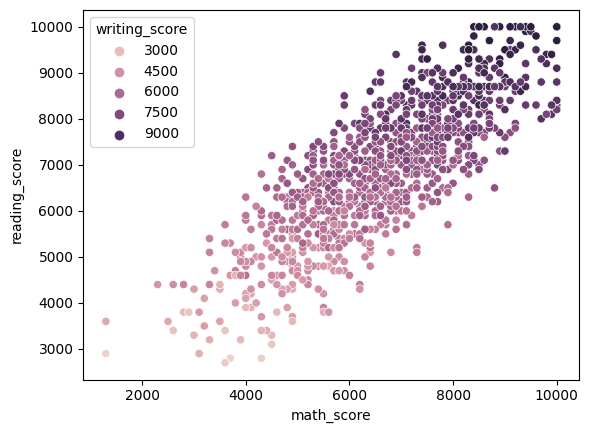

In [110]:
import seaborn as sns
sns.scatterplot(x = data.math_score, y = data.reading_score, hue = data.writing_score)

In [111]:
query2 = data_asset.getAnalytics({
        'dataset_id' : datasetId,
        'attributes' : [0,1],
        'metrics' : [6,7],
        'filters' : [],
    }, [userToken])[0]["Ok"]

print(query2['counts'])

pandaReady = []
for group in query2['analytics']:
    res = {"group_key": group['group_key'], "count": group['count']}
    for metric in group['metrics']:
        key = configClean[metric[0]]
        val = metric[1]/100/group['count']
        res[key] = val
    pandaReady.append(res)

data = pd.DataFrame(pandaReady)
data.head()

[1000, 1000, 1000, 10, 10]


,group_key,count,reading_score,writing_score
0,"""female""--""group A""",37,74.432432,73.351351
1,"""female""--""group B""",114,68.464912,68.491228
2,"""female""--""group C""",154,69.941558,69.227273
3,"""female""--""group D""",126,75.158730,76.230159
4,"""female""--""group E""",52,75.423077,73.980769


# Dynamic Datasets and Producers

In [118]:
print("Principal:", data_asset.myUser())
print("Dataset producers:", data_asset.getProducers(datasetId))
print("Is user a producer:", data_asset.isUserProducer(datasetId))

Principal: [Principal(xz3ux-kmkix-rdtnc-zxak6-w4tvt-k3zes-tv4by-buxoe-wl6m5-5m5kx-rqe)]
Dataset producers: [[[{'id': Principal(mvi6j-32kka-n6yif-ymct7-pbwnq-qklfg-ay7qo-ualxh-phwfv-vunof-aae), 'is_enabled': True, 'created_at': 1683213939656187293}, {'id': Principal(xz3ux-kmkix-rdtnc-zxak6-w4tvt-k3zes-tv4by-buxoe-wl6m5-5m5kx-rqe), 'is_enabled': True, 'created_at': 1683214760645427196}]]]
Is user a producer: [True]


In [119]:
import csv

with open(root+'/script/exams.csv', mode ='r')as file:
    csvFile = csv.reader(file)
    data = []
    for line in csvFile:
        values = []
        for idx, val  in enumerate(line):
            values.append({
                'dimension_id': idx,
                'value': {"Metric": val} if isinstance(val, int) else {"Attribute": val}

            })
        data.append({
            'id': {'Id': 10000+csvFile.line_num},
            'values': values
        })

data_asset.putManyEntries(datasetId, data)

[]

In [ ]:
# - BTC-powered
# - dataset usage, cost engine
# - incident analysis at record level
# - http outcalls
# - corrupted datapoint(s) -> email alert
# - data cleaning 

In [ ]:
IC lighthouse